In [1]:
%matplotlib inline
# Switch to ''%matplotlib ipympl' for interactive plots
import warnings
import imp
import pickle
import lmfit
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt

# Styling
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

In [2]:
# Initialise wrapper and test datasets
wrapper_fpath = (r"..\mobius.py")
wr = imp.load_source('mobius', wrapper_fpath)
wr.initialize('..\..\Applications\SimplyC\SimplyC_stage_6.dll')

# Calibration functions
calib_fpath = (r"..\mobius_calib_uncert_lmfit.py")
cu = imp.load_source('mobius_calib_uncert_lmfit', calib_fpath)

In [3]:
# Load dataset
dataset = wr.DataSet.setup_from_parameter_and_input_files('structure6_manual.dat', 
                                                          '../../Applications/SimplyC/Langtjern/langtjerninputs.dat')

In [4]:
# List of simulated and observed variables to investigate for Morsa
 comparisons = [
                #('Reach flow (daily mean, cumecs)', ['Inlet'], 'Discharge', []),
                ('Reach DOC concentration (volume weighted daily mean)', ['Inlet'], 'DOC', []),          
               ]

In [5]:
# Get parameter values defined in 'dataset'
param_df = cu.get_double_parameters_as_dataframe(dataset)
param_df

,name,unit,index,min_value,initial_value,max_value
0,Latitude,°C,(),-9.000000e+01,6.060000e+01,9.000000e+01
1,PET multiplication factor,dimensionless,(),0.000000e+00,4.888405e-01,2.000000e+00
2,Initial snow depth as water equivalent,mm,(),0.000000e+00,2.500000e+02,5.000000e+04
3,Degree-day factor for snowmelt,mm/°C/day,(),0.000000e+00,2.852837e+00,5.000000e+00
4,Proportion of precipitation that contributes t...,dimensionless,(),0.000000e+00,1.900538e-01,1.000000e+00
5,Soil field capacity,mm,(),0.000000e+00,5.000000e+01,1.000000e+03
6,Manning's coefficient,s/(m^1/3),(),1.200000e-02,9.999999e-02,1.000000e-01
7,Catchment area,km^2,"(Inlet,)",0.000000e+00,8.000000e-01,1.000000e+04
8,Reach length,m,"(Inlet,)",0.000000e+00,8.000000e+02,1.000000e+07
9,Reach slope,m/m,"(Inlet,)",1.000000e-05,2.000000e-02,3.000000e+00



Goodness of fit for Reach DOC concentration (volume weighted daily mean) [Inlet] vs DOC []:
Mean error (bias): -0.069922
Mean absolute error: 1.433134
Root mean square error: 1.904292
Nash-Sutcliffe coefficient: 0.638280
Number of observations: 1067



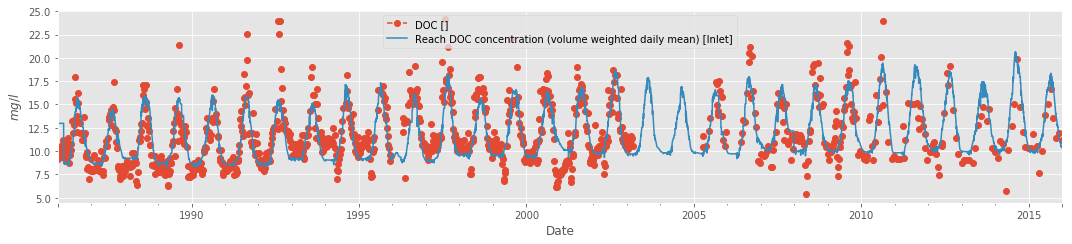

In [6]:
# Plot results from manual calibration
dataset.run_model()
cu.print_goodness_of_fit(dataset, comparisons)
cu.plot_objective(dataset, comparisons)

In [7]:
# Get params to be calibrated
vars = [
    18, 19, 20, 22, 23
]

calib_df = param_df.loc[vars].reset_index(drop=True)
calib_df

,name,unit,index,min_value,initial_value,max_value
0,Soil temperature DOC concentration linear coef...,mg/l/°C,(),-1.797693e+308,2.399470e-12,1.797693e+308
1,Soil temperature DOC concentration square coef...,mg/l/(°C)^2,(),-1.797693e+308,1.134033e-01,1.797693e+308
2,Soil carbon solubility response to SO4 deposition,dimensionless,(),0.000000e+00,5.699513e-01,2.000000e+01
3,Soil DOC equilibration factor,km2/day,(),0.000000e+00,5.000000e+02,1.000000e+01
4,Baseline soil water DOC concentration,mg/l,"(Forest and bog,)",0.000000e+00,1.034316e+01,7.000000e+01


In [9]:
# Add 'short_name' column for calibrating parameters
calib_df['short_name'] = [
    #'alphaPET',
    #'DDFmelt',
    #'fquick',
    #'c_m',
    #'Ts',
    #'sdst',
    #'stc',
    'kT1',
    'kT2',
    'kSO4',
    #'DOCmelt',
    'cEq',
    'DOCsbase',
]

In [10]:
# Convert to LMFit parameter object
params = cu.parameter_df_to_lmfit(calib_df)


params['kT1'].min = 0.0
params['kT1'].max = 5.0
params['kT2'].min = -0.1
params['kT2'].max = 0.5

params['kSO4'].min = 0.0
params['kSO4'].max = 10.0

params['cEq'].min = 1.0
params['cEq'].max = 1000.0

# Optionally refine prior ranges
#params['DDFmelt'].min = 0.05
#params['DDFmelt'].max = 4

#params['fquick'].min = 0.0
#params['fquick'].max = 0.2

#params['Ts'].max = 15

#params['T_g'].max = 200

#params['DOCsoilT'].max = 2.0

params

name,value,initial value,min,max,vary
kT1,2.3995e-12,2.3994695119711224e-12,0.00000000,5.00000000,True
kT2,0.11340333,0.11340332854897209,-0.10000000,0.50000000,True
kSO4,0.56995130,0.5699513005372644,0.00000000,10.0000000,True
cEq,10.0000000,500.0,1.00000000,1000.00000,True
DOCsbase,10.3431564,10.34315638081,0.00000000,70.0000000,True


In [13]:
%%time

dataset.set_parameter_uint('Timesteps', [], 6573) #make it run only for the calibration period

mi, res = cu.minimize_residuals(params, dataset, comparisons, method='nelder', norm=False, 
                                skip_timesteps=365)

print('Optimisation results:\n')
lmfit.report_fit(res)
print('\n\nOptimised parameter values:\n')
res.params.pretty_print(precision=3)

Optimisation results:

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 877
    # data points      = 788
    # variables        = 5
    chi-square         = 2611.81276
    reduced chi-square = 3.33564848
    Akaike info crit   = 954.261751
    Bayesian info crit = 977.609242
[[Variables]]
    kT1:       1.4281e-04 +/- 0.00308480 (2160.00%) (init = 2.39947e-12)
    kT2:       0.11400826 +/- 0.00299056 (2.62%) (init = 0.1134033)
    kSO4:      0.57292589 +/- 0.09782094 (17.07%) (init = 0.5699513)
    cEq:       965.097983 +/- 99.1563812 (10.27%) (init = 10)
    DOCsbase:  10.3627057 +/- 0.24248999 (2.34%) (init = 10.34316)
[[Correlations]] (unreported correlations are < 0.100)
    C(kSO4, DOCsbase) =  0.929
    C(kT2, DOCsbase)  = -0.275
    C(kT1, kT2)       = -0.119


Optimised parameter values:

Name         Value      Min      Max   Stderr     Vary     Expr Brute_Step
DOCsbase      10.4        0       70    0.242     True     None     None
cEq         


Goodness of fit for Reach DOC concentration (volume weighted daily mean) [Inlet] vs DOC []:
Mean error (bias): -0.014140
Mean absolute error: 1.423944
Root mean square error: 1.885944
Nash-Sutcliffe coefficient: 0.645217
Number of observations: 1067



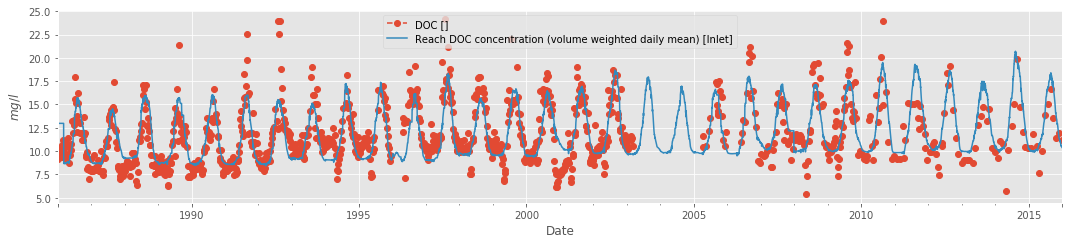

In [14]:
# Plot results from optimisation
cu.set_parameter_values(res.params, dataset)
dataset.set_parameter_uint('Timesteps', [], 10957) #Set back so that the saved file has the right amount of timesteps

dataset.run_model()
cu.print_goodness_of_fit(dataset, comparisons)
cu.plot_objective(dataset, comparisons)
dataset.write_parameters_to_file('structure6_auto.dat')